<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


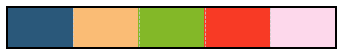

In [1]:
import seaborn as sns
import sys
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

sys.path.append(r'..')
sys.path.append(r'.')
%load_ext autoreload
%autoreload 2

from process_data import process_mutation_data
from statistical_test import *

In [2]:
def violin_plot_for_mutation_distance(df, experiment_name, fig_name, split=True, inner='quart', density_norm='area', width=0.8, x_order=None):
    # tol palette, color-blind friendly
    plt.rcParams.update({'axes.edgecolor': 'black', 'axes.linewidth': 2, 'axes.grid': True, 'grid.linestyle': '--'})
    plt.rcParams['figure.figsize'] = 7, 3
    custom_palette = {'Zest-all': '#DD8452', 'Zest-saved': '#BEBADA', 'GEX-all': '#4C72B0'}
    tmp_ax = sns.violinplot(data=df, x='benchmark_name', y='mutation', hue='algorithm',
                            split=split, inner=inner, density_norm=density_norm, palette=custom_palette,
                            width=width, linewidth=1.0, order=x_order, common_norm=True, saturation=1)
    sns.move_legend(tmp_ax, "lower center", bbox_to_anchor=(.5, 1), ncol=4, title=None, frameon=False)
    for l in tmp_ax.lines:
        l.set_linestyle(':')
        l.set_linewidth(1)
        l.set_color('black')
        l.set_alpha(0.8)
    for l in tmp_ax.lines[1::3]:
        l.set_linestyle('-')
        l.set_linewidth(1.6)
        l.set_color('#F7F056')
        l.set_alpha(0.8)

    # get rid of ticks for empty columns (levels)
    if x_order:
        x_arr = np.array(x_order)
        position_arr = np.array(range(0, len(x_order)))
        positions = [p for p, order in zip(position_arr, x_arr) if 'NA' not in order]
        filtered_x = [e for e in list(x_order) if 'NA' not in e]
        tmp_ax.set_xticks(positions)
        tmp_ax.set_xticklabels(filtered_x)
        plt.xticks(rotation=30)

    tmp_ax.set(xlabel='Benchmark', ylabel='Mutation Distance (%)')
    # tmp_ax.grid(False)
    plt.savefig('./figs/{}_{}.pdf'.format(experiment_name, fig_name), bbox_inches='tight', pad_inches=0.1)

In [3]:
def box_plot_for_mutation_distance(df, experiment_name, fig_name):
    tmp_ax = sns.boxplot(data=df, x='benchmark_name', y='mutation', hue='algorithm')
    sns.move_legend(tmp_ax, "lower center", bbox_to_anchor=(.5, 1), ncol=3, title=None, frameon=False)
    plt.savefig('./figs/{}_{}.png'.format(experiment_name, fig_name), dpi=300)

In [5]:
def beautify_stats_table(groupby):
    stats = groupby.describe()
    processed_stats = stats.loc[:, (slice(None), ['', 'count', '50%', 'mean', 'std', 'min', 'max'])].rename(columns={'50%':'median'})
    return processed_stats

def bar_plot_for_median_mutation_distance(stats_df, experiment_name, fig_name):
    # get the median values
    median_mutation_df = stats_df.loc[:, (slice(None), ['', 'median'])]
    # flatten the index
    median_mutation_df.columns = median_mutation_df.columns.get_level_values(0)
    # reorder the index
    # median_mutation_df = median_mutation_df.reindex([0, 5, 6, 1, 2, 3, 4, 7, 12, 13, 8, 9, 10, 11]).reset_index(drop=True)
    # bar plot
    tmp_ax = sns.barplot(median_mutation_df, x='benchmark_name', y='mutation', hue='algorithm')
    sns.move_legend(tmp_ax, "lower center", bbox_to_anchor=(.5, 1), ncol=3, title=None, frameon=False)
    plt.savefig('./figs/{}_{}.png'.format(experiment_name, fig_name), dpi=300)

In [4]:
# statistical tests
def mann_whitney_u_test_for_mutation_distance(df, groupby, alg1_name, alg2_name):
    # TODO: remove either df or groupby
    result_dict = {}
    test_names = ['two-sided', 'less']
    measures = ['p', 'A_12', 'U1', 'U2', 'r1', 'r2']
    indices = []
    for name in test_names:
        indices += ['{}_{}'.format(name, measure) for measure in measures]

    # Warning: large and unequal sample sizes will result in timeout; debugging required
    for benchmark_name in df.benchmark_name.unique():
        print('testing {}...'.format(benchmark_name))
        alg1_data = groupby.get_group((alg1_name, benchmark_name)).mutation.values
        alg2_data = groupby.get_group((alg2_name, benchmark_name)).mutation.values
        print('sample1 size: {}, sample2 size: {}'.format(len(alg1_data), len(alg2_data)))
        result_two_sided = mann_whitney_u_test(alg1_data, alg2_data, alternative=test_names[0], verbose=False)
        result_one_sided = mann_whitney_u_test(alg1_data, alg2_data, alternative=test_names[1], verbose=False)
        result_dict[benchmark_name] = list(result_two_sided) + list(result_one_sided)
    # create the dataframe
    stats_df = pd.DataFrame(result_dict, index=indices)
    return stats_df

# RQ1: How destructive are Zest's mutations in general? Are disruptive mutations beneficial for fuzzing?

In [5]:
experiment_name1 = 'ei-d430-m1'
experiment_name2 = 'ei-d430-m2'
# process_mutation_data('/data/aoli/results-JQF/{}/'.format(experiment_name1), [False, True], ["testWithGenerator"], ["zest", "ei-no-havoc"], 'mutation1')
# process_mutation_data('/data/aoli/results-JQF/{}/'.format(experiment_name2), [False, True], ["testWithGenerator"], ["zest", "ei-no-havoc"], 'mutation2')
# # load the df from pickle
# mutation_df1 = pd.read_pickle('./mutation1.pkl')
# mutation_df2 = pd.read_pickle('./mutation2.pkl')
# mutation_df = pd.concat([mutation_df1, mutation_df2], ignore_index=True, sort=False)
# mutation_df.to_pickle('./mutation.pkl')

In [6]:
experiment_name = 'v_dec10'
mutation_df = pd.read_pickle('./mutation.pkl')

In [7]:
new_label_names = {'zest-testWithGenerator': 'Zest-all', 'zest-testWithGenerator-saved_only': 'Zest-saved', 'ei-no-havoc-testWithGenerator': 'GEX-all', 'ei-no-havoc-testWithGenerator-saved_only': 'GEX-saved'}
mutation_df['algorithm'] = mutation_df['algorithm'].map(new_label_names)
print(mutation_df['algorithm'].unique())

['Zest-all' 'Zest-saved' 'GEX-all' 'GEX-saved']


In [8]:
zest_df = mutation_df[mutation_df['algorithm'].str.contains('Zest')]
# ei_df = mutation_df[~mutation_df.index.isin(zest_df.index)]
all_input_df = mutation_df[mutation_df['algorithm'].str.contains('all')]
print(all_input_df.benchmark_name.unique())

['ant' 'maven' 'rhino' 'closure' 'chocopy' 'gson' 'jackson']


In [9]:
non_zero_mutation_df = mutation_df[mutation_df['mutation'] != 0]
non_zero_zest_df = non_zero_mutation_df[mutation_df['algorithm'].str.contains('Zest')]
non_zero_all_input_df = non_zero_mutation_df[mutation_df['algorithm'].str.contains('all')]

/tmp/ipykernel_1589400/3758107138.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  non_zero_zest_df = non_zero_mutation_df[mutation_df['algorithm'].str.contains('Zest')]
/tmp/ipykernel_1589400/3758107138.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  non_zero_all_input_df = non_zero_mutation_df[mutation_df['algorithm'].str.contains('all')]


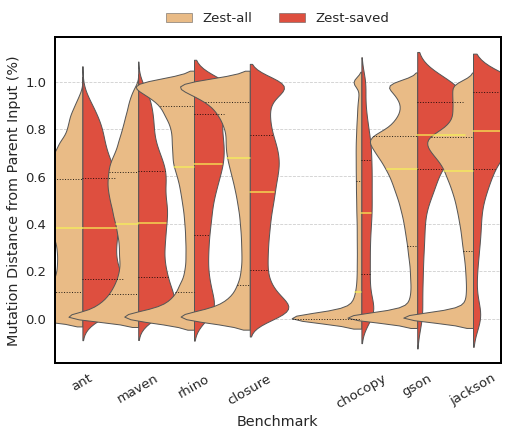

In [15]:
# zest all inputs vs. zest saved inputs
x_order = ('ant', 'maven', 'rhino', 'closure', 'NA1', 'chocopy', 'gson', 'jackson')
violin_plot_for_mutation_distance(zest_df, experiment_name, 'rq1_zest_all_vs_saved', width=2.5, x_order=x_order)

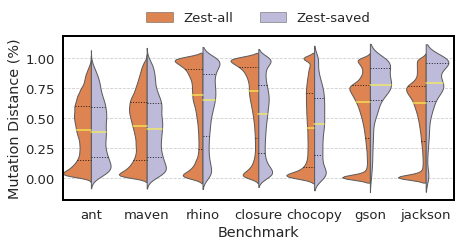

In [10]:
violin_plot_for_mutation_distance(non_zero_zest_df, experiment_name, 'rq1_wo_zero_mutations', width=1.0)

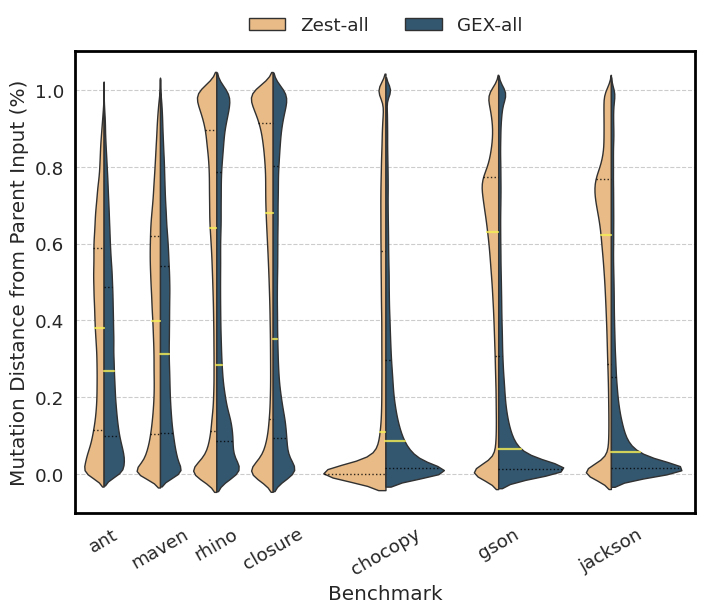

In [41]:
x_order = ('ant', 'maven', 'rhino', 'closure', 'NA1', 'chocopy', 'NA2', 'gson', 'NA3', 'jackson', 'NA4')
violin_plot_for_mutation_distance(all_input_df, experiment_name, 'rq2_zest_vs_ei', width=2.5, x_order=x_order)

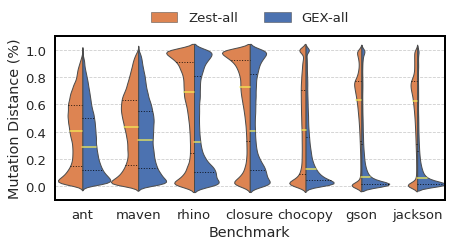

In [11]:
# x_order = ('ant', 'maven', 'rhino', 'closure', 'chocopy',  'gson',  'jackson')
violin_plot_for_mutation_distance(non_zero_all_input_df, experiment_name, 'rq2_wo_zero_mutations', width=1)

   algorithm benchmark_name        p
0    GEX-all            ant   3.6826
1    GEX-all        chocopy  15.5913
2    GEX-all        closure   5.2815
3    GEX-all           gson   0.9424
4    GEX-all        jackson   0.5566
5    GEX-all          maven   4.9065
6    GEX-all          rhino   4.5598
7   Zest-all            ant   4.9345
8   Zest-all        chocopy  31.3339
9   Zest-all        closure   8.4641
10  Zest-all           gson   1.3774
11  Zest-all        jackson   1.1022
12  Zest-all          maven   6.6242
13  Zest-all          rhino   8.3100
GEX-all
Zest-all
GEX-all
Zest-all
GEX-all
Zest-all
GEX-all
Zest-all
GEX-all
Zest-all
GEX-all
Zest-all
GEX-all
Zest-all


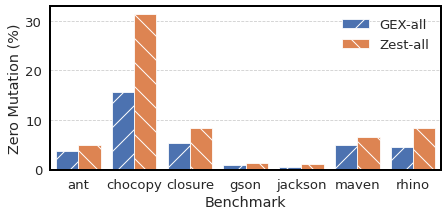

In [21]:
import matplotlib.patches as mpatches

zero_count = all_input_df.groupby(['algorithm', 'benchmark_name']).apply(lambda x: (x['mutation'] == 0).sum())
total_count = all_input_df.groupby(['algorithm', 'benchmark_name'])['mutation'].count()
# n_zero_count = all_input_df.groupby(['algorithm', 'benchmark_name']).apply(lambda x: (x['mutation'] != 0).sum())
plt.rcParams.update({'axes.edgecolor': 'black', 'axes.linewidth': 2, 'axes.grid': True, 'grid.linestyle': '--'})
plt.rcParams['figure.figsize'] = 7, 3
result = pd.DataFrame({'p': zero_count/total_count *100}).reset_index()
print(result)
custom_palette = {'Zest-all': '#DD8452', 'Zest-saved': '#BEBADA', 'GEX-all': '#4C72B0'}
ax = sns.barplot(result, x="benchmark_name", y="p", hue="algorithm", palette=custom_palette, saturation=1)


patterns = ['/', '\\']
algo = ["GEX-all", "Zest-all"]

unique_hues = result['algorithm'].unique()
pattern_dict = {hue: patterns[i % len(patterns)] for i, hue in enumerate(unique_hues)}
# print(hue_pattern)

# print(dict(zip(axis.patches, all_data['Algorithm'])))
# Apply the hatch pattern based on the hue
sorted_patches = sorted(ax.patches, key=lambda patch: patch.get_x())
x = 0
legend_handles = []
for bar in sorted_patches:
    hue_value = algo[x%2]
    print(hue_value)
    bar.set_hatch(pattern_dict[hue_value])
    x += 1

    if hue_value not in [h.get_label() for h in legend_handles]:
        legend_handles.append(mpatches.Patch(facecolor=bar.get_facecolor(),
                                            hatch=pattern_dict[hue_value],
                                            label=hue_value))




plt.legend(handles=legend_handles)


sns.move_legend(ax, "upper right",  title=None, frameon=False)
ax.set(xlabel='Benchmark', ylabel='Zero Mutation (%)')
fig = ax.get_figure()
fig.savefig("/usr0/home/aoli/repos/ei-paper/figs/zero.pdf", bbox_inches='tight', pad_inches=0.1)
plt.show()
# print(n_zero_count)

In [13]:
# stats table
groupby = all_input_df.groupby(['algorithm', 'benchmark_name'], as_index=False)
all_input_stats = beautify_stats_table(groupby)
all_input_stats
# bar_plot_for_median_mutation_distance(all_input_stats, experiment_name, 'all_input_bar_plot')
# box_plot_for_mutation_distance(zest_df, experiment_name, 'zest_box_plot')

algorithm benchmark_name   mutation                                     \
                                 count    median      mean       std  min   
0    GEX-all            ant  1000000.0  0.268293  0.311858  0.239864  0.0   
1    GEX-all        chocopy  1000000.0  0.085714  0.205313  0.263733  0.0   
2    GEX-all        closure  1000000.0  0.352459  0.434631  0.357525  0.0   
3    GEX-all           gson  1000000.0  0.065390  0.217223  0.296558  0.0   
4    GEX-all        jackson  1000000.0  0.057953  0.190841  0.267425  0.0   
5    GEX-all          maven  1000000.0  0.312000  0.343703  0.260139  0.0   
6    GEX-all          rhino  1000000.0  0.282609  0.411665  0.357830  0.0   
7   Zest-all            ant  1000000.0  0.380531  0.373124  0.262650  0.0   
8   Zest-all        chocopy  1000000.0  0.110294  0.293360  0.336459  0.0   
9   Zest-all        closure  1000000.0  0.679245  0.567409  0.370488  0.0   
10  Zest-all           gson  1000000.0  0.630600  0.540479  0.315079  0.0   
11  Zest-all        jackson  1000000.0  0.621951  0.530217  0.313515  0.0   
12  Zest-all          maven  1000000.0  0.398782  0.387303  0.281739  0.0   
13  Zest-all          rhino  1000000.0  0.639774  0.540594  0.372511  0.0   

              
         max  
0   0.982568  
1   1.000000  
2   1.000000  
3   0.999663  
4   0.999656  
5   0.995632  
6   1.000000  
7   0.988689  
8   1.000000  
9   1.000000  
10  0.999675  
11  0.999654  
12  0.996517  
13  1.000000